In [63]:
%load_ext autoreload
%autoreload 2

#%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rotation curves

First, imports:

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import astropy.units as u
from astropy.constants import G

import snapshot_obj 
import curve_fit

import importlib

In [116]:
importlib.reload(snapshot_obj)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/kassiili/Curvaton_Simulations/analysis/curve_fit.py'>

## Get data

In [140]:
# Which halo:
gn = 2; sgn = 0

# Ones that seem alright: 12,0;

# Get LCDM data:
LCDM = snapshot_obj.Snapshot("CDM_V1_LR",127)

In [141]:
# Read halo:
fnum = LCDM.file_of_halo(gn,sgn)
SGNs = LCDM.get_subhalos("SubGroupNumber",fnums=[fnum])
GNs = LCDM.get_subhalos("GroupNumber",fnums=[fnum])

vmax = LCDM.get_subhalos("Vmax",fnums=[fnum]) / 100000 
                                                    # cm/s to km/s 
rmax = LCDM.get_subhalos("VmaxRadius",fnums=[fnum]) \
            * u.cm.to(u.kpc)
COP = LCDM.get_subhalos("CentreOfPotential",fnums=[fnum]) \
            * u.cm.to(u.kpc)

print(np.mean(rmax))
print(np.median(rmax))
print(np.min(rmax),np.max(rmax))
print(rmax.size)

# Select halo:
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
print(halo_mask)
vmax = vmax[halo_mask]
rmax = rmax[halo_mask]
COP = COP[halo_mask]
print(rmax)

23.671940158641757
7.17106838188119
0.9263269285443926 354.28647947401424
64
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False]
[291.28967417]


In [142]:
# V1kpc:
SGNs = LCDM.get_subhalos("SubGroupNumber")
GNs = LCDM.get_subhalos( "GroupNumber")
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
v1kpc = LCDM.get_subhalos("V1kpc") 
v1kpc = v1kpc[halo_mask]

here, dm1 part n = 1759284
here, dm2 part n = 614994
here, dm3 part n = 1047484


In [143]:
r = {}
v_circ = {}
pts = {'gas' : [0], 'dm' : [1], 'stars' : [4], 'BHs' : [5], 'all' : [0,1,4,5]}
# Read particles:
for key,pt in pts.items():
    SGNs = LCDM.get_particles("SubGroupNumber",part_type=pt)
    GNs = LCDM.get_particles("GroupNumber",part_type=pt)
    coords = LCDM.get_particles("Coordinates",part_type=pt) * u.cm.to(u.kpc)
    mass = LCDM.get_particle_masses(part_type=pt) * u.g.to(u.Msun)
    
    # Select halo:
    halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
    masks[key] = halo_mask
    coords = coords[halo_mask]
    mass = mass[halo_mask]
    
    # Periodic wrap coordinates around centre.
    with h5py.File(LCDM.part_file,'r') as partf:
        h = partf['link1/Header'].attrs.get('HubbleParam')
        boxs = partf['link1/Header'].attrs.get('BoxSize') * 1000/h 
                                                        # Mpc/h -> kpc
    coords = np.mod(coords-COP+0.5*boxs, boxs) + COP-0.5*boxs

    # Calculate distance to centre and sort:
    d = np.linalg.norm(coords - COP, axis=1)
    sorting = np.argsort(d)
    d = d[sorting]
    
    cumass = np.cumsum(mass[sorting])
    
    # Begin rotation curve from the 10th particle to reduce noise at the low end of the curve.include only every 10th particle for cleaner curves.
    mask = d>0; d=d[mask]; cumass=cumass[mask]
    jump = 20
    #r = r[jump::jump]
    #cumass = cumass[jump::jump]
    d = d[jump:]
    cumass = cumass[jump:]
    
    # Compute velocity.
    myG = G.to(u.km**2 * u.kpc * u.Msun**-1 * u.s**-2).value
    v_circ[key] = np.sqrt((myG * cumass) / d)
    r[key] = d


here, dm1 part n = 1759284
here, dm1 part n = 1759284


/home/kassiili/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


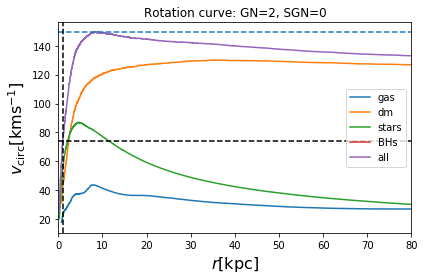

In [144]:
fig, axes = plt.subplots()

# Set axes:
#axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlim(0,80)
#axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$r[\mathrm{kpc}]$', fontsize=16)
axes.set_ylabel('$v_{\mathrm{circ}}[\mathrm{kms^{-1}}]$', fontsize=16)

# Galaxy text:
axes.set_title('Rotation curve: GN={}, SGN={}'.format(gn,sgn))

for key in pts.keys():
    axes.plot(r[key], v_circ[key], label=key)
axes.axhline(vmax,linestyle='dashed')
axes.axvline(rmax,linestyle='dashed')
axes.axhline(v1kpc,linestyle='dashed',c='black')
axes.axvline(1,linestyle='dashed',c='black')
    
plt.legend()
plt.tight_layout()


# Save figure:
#
#filename = 'cumulDistByVmax_evol_{}.png'.format(galaxy)
#
#home = os.path.dirname(snapshot_obj.__file__)
#path = os.path.join(home,"Figures")
#
## If the directory does not exist, create it
#if not os.path.exists(path):
#    os.makedirs(path)
#plt.savefig(os.path.join(path,filename), dpi=200)